# 3_modeling_suto

**Purpose:** State the purpose of the notebook.

**Methodology:** Quickly describe assumptions and processing steps.

**Results:** Describe and comment the most important results.

---

**Suggested next steps**

- [ ] State suggested next steps, based on results obtained in this notebook.

# Setup

## Library import
We import all the required Python libraries

In [2]:
import os
from typing import List, Union
import warnings

# Data manipulation
from boruta import BorutaPy
import numpy as np
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

os.chdir('../')
from src.utils.data_describe import breve_descricao, serie_nulos, cardinalidade
os.chdir('./notebooks/')

# Options for pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

warnings.filterwarnings("ignore")

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

### Custom functions

In [3]:
def rfr_feature_selection(
    df: pd.DataFrame, minimal_importance: float = 0.001, lst_columns: Union[str, List] = []
) -> List:
    importance = minimal_importance
    dct_performance = {}
    
    if len(lst_columns) == 0:
        lst_columns = df.columns.tolist()
    
    while len(lst_columns) > 1:
        model = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
        model.fit(X_train[lst_columns], y_train.values)
        y_pred = model.predict(X_test[lst_columns])
        dct_performance[len(lst_columns)] = {"features": lst_columns, 'RMSE': mse(y_test, y_pred)**.5}
        lst_columns = df_importance.loc[df_importance['importance']>importance].index.tolist()
        importance += 0.005
        
    return dct_performance

## Parameter definition

We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [4]:
RAW_FOLDER = '../data/raw/'
INTERIM_FOLDER = '../data/interim/'
PROCESSED_FOLDER = '../data/processed/'
REPORTS_FOLDER = '../reports/'
RANDOM_STATE = 42


# Data import
We retrieve all the required data for the analysis.

In [5]:
df = pd.read_parquet(INTERIM_FOLDER + 'df_train_interim_01_baseline.pqt')
df_evaluation = df.copy() 
print(f"df_evaluation's shape: {df_evaluation.shape}")

# Importing Kaggle's test dataset.
x_test_kaggle = pd.read_parquet(INTERIM_FOLDER + 'x_test_kaggle_prepared_baseline.pqt')
print(f"x_test_kaggle's shape: {x_test_kaggle.shape}")

df_evaluation's shape: (1460, 19)
x_test_kaggle's shape: (1459, 18)


## Splitting data in training and validation datasets

In [6]:
X = df_evaluation.drop(columns=['SalePrice'])
y = df_evaluation[['SalePrice']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# 1st experiment: Simple linear regression

This 1st experiment has the purpose to set a baseline to our model.

## Modeling and evaluating with the validation data

RMSE: 40198.72


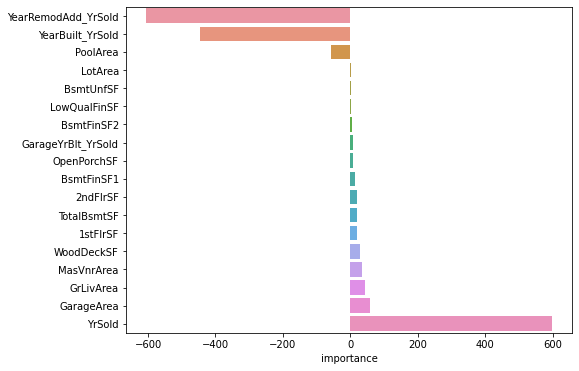

In [7]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

coef_importance = pd.DataFrame(model.coef_[0], index=X_train.columns).sort_values(by=0, ascending=True)
coef_importance.rename(columns={0: 'importance'}, inplace=True)

a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=coef_importance, y=coef_importance.index, x='importance', ax=ax);

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

## Testing the Kaggle's test dataset

In [8]:
x_test_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   LotArea              1459 non-null   int64  
 1   MasVnrArea           1459 non-null   float64
 2   BsmtFinSF1           1459 non-null   float64
 3   BsmtFinSF2           1459 non-null   float64
 4   BsmtUnfSF            1459 non-null   float64
 5   TotalBsmtSF          1459 non-null   float64
 6   1stFlrSF             1459 non-null   int64  
 7   2ndFlrSF             1459 non-null   int64  
 8   LowQualFinSF         1459 non-null   int64  
 9   GrLivArea            1459 non-null   int64  
 10  GarageArea           1459 non-null   float64
 11  WoodDeckSF           1459 non-null   int64  
 12  OpenPorchSF          1459 non-null   int64  
 13  PoolArea             1459 non-null   int64  
 14  YrSold               1459 non-null   int64  
 15  YearBuilt_YrSold     1459 non-null 

In [9]:
y_pred_kaggle = model.predict(x_test_kaggle)
y_pred_kaggle = pd.DataFrame(y_pred_kaggle, index=x_test_kaggle.index, columns=['SalePrice']).reset_index()
y_pred_kaggle.rename(columns={'index':'Id'}, inplace=True)
y_pred_kaggle.sample(10, random_state=RANDOM_STATE)

,Id,SalePrice
1321,2782,88882.905215
836,2297,268186.559189
413,1874,157618.145918
522,1983,202118.136560
1035,2496,248852.367410
614,2075,157944.900049
218,1679,317485.446384
1031,2492,193763.232067
1289,2750,110524.726125
886,2347,198759.393734


In [10]:
y_pred_kaggle.to_csv(PROCESSED_FOLDER + 'y_pred_kaggle_baseline_linear_regression.csv', index=False)

# 2nd experiment: Random forest regressor with default hyperparameters
 
This experiment has the purpose to compare the performance between a parametric method and a non-parametric model.

## Modeling and evaluating with the validation data

In [11]:
model = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)
model.fit(X_train, y_train.values)

y_pred = model.predict(X_test)

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

RMSE: 31725.89


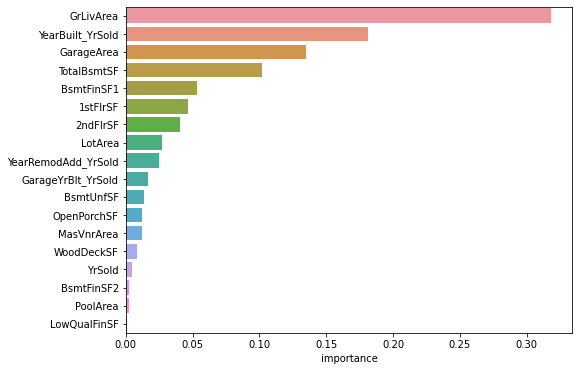

In [12]:
df_importance = pd.DataFrame(
    model.feature_importances_, index=model.feature_names_in_, columns=['importance']
).sort_values(by='importance', ascending=False)


a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=df_importance, y=df_importance.index, x='importance', ax=ax);

## Testing the Kaggle's test dataset

In [13]:
y_pred_kaggle = model.predict(x_test_kaggle)
y_pred_kaggle = pd.DataFrame(y_pred_kaggle, index=x_test_kaggle.index, columns=['SalePrice']).reset_index()
y_pred_kaggle.rename(columns={'index':'Id'}, inplace=True)
y_pred_kaggle.sample(10, random_state=RANDOM_STATE)

,Id,SalePrice
1321,2782,101946.000000
836,2297,311331.880000
413,1874,141880.666667
522,1983,201130.600000
1035,2496,224825.800000
614,2075,148259.500000
218,1679,395034.630000
1031,2492,197361.000000
1289,2750,135898.120000
886,2347,207506.060000


In [14]:
y_pred_kaggle.to_csv(PROCESSED_FOLDER + 'y_pred_kaggle_baseline_random_forest_default.csv', index=False)

# 3rd experiment: Random forest regressor with grid search

## Grid search

I'll try to follow these steps:

1. Use RandomizedSearchCV in a broader range for each hyperparameter;
2. After find the best candidate in the previous step, search in a smaller area around the point obtained.

### RandomizedSearchCV

In [15]:
hyperparameter_search_space = dict(
    n_estimators=np.arange(200, 1000, 1000).tolist(),
    max_depth=np.arange(int(len(X_train.columns)**.5), int(len(X_train.columns))+1, 2).tolist(),
    min_samples_split=np.arange(2, 20, 2).tolist(),
    min_samples_leaf=np.arange(1, 20, 2).tolist(),
    max_features=['sqrt', 'log2', len(X_train.columns)-2, len(X_train.columns)],
    ccp_alpha=np.arange(0, 0.05, 0.005).tolist(),
)

hyperparameter_search_space

{'n_estimators': [200],
 'max_depth': [4, 6, 8, 10, 12, 14, 16, 18],
 'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18],
 'min_samples_leaf': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
 'max_features': ['sqrt', 'log2', 16, 18],
 'ccp_alpha': [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045]}

In [16]:
model = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)

random_grid_search = RandomizedSearchCV(model, hyperparameter_search_space, random_state=RANDOM_STATE, n_iter=50)
search = random_grid_search.fit(X_train, y_train)
search.best_params_

{'n_estimators': 200,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_features': 18,
 'max_depth': 16,
 'ccp_alpha': 0.0}

### Modeling and evaluating with the validation data

In [17]:
model = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE, **search.best_params_)
model.fit(X_train, y_train.values)

y_pred = model.predict(X_test)

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

RMSE: 31994.30


In [18]:
y_pred_kaggle = model.predict(x_test_kaggle)
y_pred_kaggle = pd.DataFrame(y_pred_kaggle, index=x_test_kaggle.index, columns=['SalePrice']).reset_index()
y_pred_kaggle.rename(columns={'index':'Id'}, inplace=True)
y_pred_kaggle.sample(10, random_state=RANDOM_STATE)

,Id,SalePrice
1321,2782,101591.283515
836,2297,302812.574188
413,1874,141381.879851
522,1983,201842.053327
1035,2496,237629.387447
614,2075,150311.746399
218,1679,390212.902104
1031,2492,197390.003635
1289,2750,136082.106259
886,2347,210196.614681


In [19]:
model.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(max_depth=16, max_features=18, min_samples_split=8,
                      n_estimators=200, n_jobs=-1, random_state=42)>

In [20]:
y_pred_kaggle.to_csv(PROCESSED_FOLDER + 'y_pred_kaggle_baseline_random_forest_random_grid_search.csv', index=False)

### Partial concluision

The hyperparameters obtained by the random search do not reduced the RMSE. So I will not try the grid search for now.

# 4th experiment: Feature selection + Random Forest Regressor

Using the same baseline dataset, remove some of the features with less importance and evaluate the impact in RMSE.

## Getting the feature importance

RMSE: 31725.89


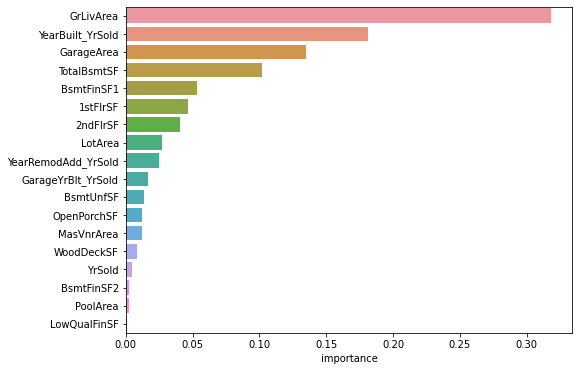

In [21]:
model = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
model.fit(X_train, y_train.values)

y_pred = model.predict(X_test)

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

df_importance = pd.DataFrame(
    model.feature_importances_, index=model.feature_names_in_, columns=['importance']
).sort_values(by='importance', ascending=False)


a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=df_importance, y=df_importance.index, x='importance', ax=ax);

### Evaluating the feature selection through feature importance

I will see the impact of feature selection in the RMSE.

In [22]:
dct_performance = rfr_feature_selection(df=X_train)
pd.DataFrame.from_dict(dct_performance, orient='index').sort_values(by='RMSE', ascending=True)

,features,RMSE
9,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",30325.063697
10,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",30623.545931
13,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",30721.899910
8,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",31046.455787
14,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",31228.334743
18,"[LotArea, MasVnrArea, BsmtFinSF1, BsmtFinSF2, ...",31725.887225
17,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",31923.648801
6,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",32416.133314
5,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",32513.871299
4,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",32708.542754


RMSE: 30623.55


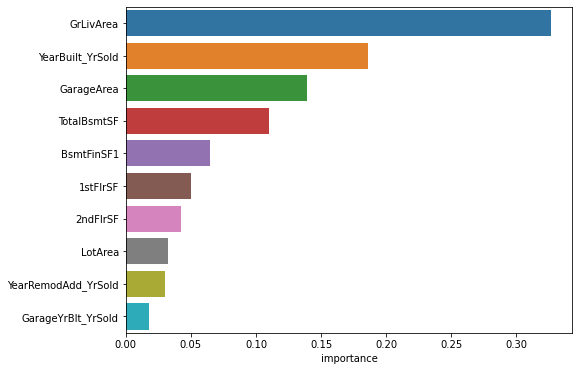

In [23]:
lst_columns = dct_performance[10]['features']

model = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
model.fit(X_train[lst_columns], y_train.values)

y_pred = model.predict(X_test[lst_columns])

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

df_importance = pd.DataFrame(
    model.feature_importances_, index=model.feature_names_in_, columns=['importance']
).sort_values(by='importance', ascending=False)


a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=df_importance, y=df_importance.index, x='importance', ax=ax);

In [24]:
x_test_kaggle_reduced = x_test_kaggle[lst_columns].copy()

y_pred_kaggle = model.predict(x_test_kaggle_reduced[lst_columns])
y_pred_kaggle = pd.DataFrame(y_pred_kaggle, index=x_test_kaggle_reduced.index, columns=['SalePrice']).reset_index()
y_pred_kaggle.rename(columns={'index':'Id'}, inplace=True)
y_pred_kaggle.sample(10, random_state=RANDOM_STATE)

,Id,SalePrice
1321,2782,99389.00
836,2297,317451.67
413,1874,142310.00
522,1983,201026.55
1035,2496,223975.59
614,2075,143911.50
218,1679,385395.15
1031,2492,192156.50
1289,2750,135175.25
886,2347,208197.87


In [25]:
y_pred_kaggle.to_csv(PROCESSED_FOLDER + 'y_pred_kaggle_baseline_random_forest_random_rfr_feature_selection.csv', index=False)

### Partial conclusion

Even with a lower RMSE for the validation dataset, the score obtained with the test score in Kaggle's leaderboard do not presented a decrease. The strategy must change once again. This time, I'm going to add some categorical attributes in a random forest regressor. 

# 5th experiment: Added binary attributes

## Importing data

In [26]:
df = pd.read_parquet(INTERIM_FOLDER + 'df_train_interim_02_2nd_experiment.pqt')
df_evaluation = df.copy() 
print(f"df_evaluation's shape: {df_evaluation.shape}")

# Importing Kaggle's test dataset.
x_test_kaggle = pd.read_parquet(INTERIM_FOLDER + 'x_test_kaggle_prepared_2nd_experiment.pqt')
print(f"x_test_kaggle's shape: {x_test_kaggle.shape}")

df_evaluation's shape: (1460, 25)
x_test_kaggle's shape: (1459, 24)


### Splitting data

In [27]:
X = df_evaluation.drop(columns=['SalePrice'])
y = df_evaluation[['SalePrice']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### Modeling

RMSE: 32042.66


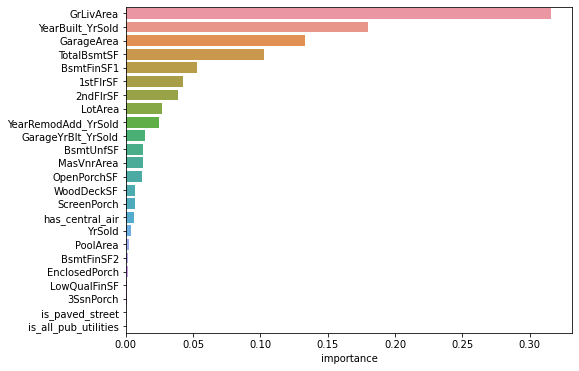

In [28]:
model = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
model.fit(X_train, y_train.values)

y_pred = model.predict(X_test)

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

df_importance = pd.DataFrame(
    model.feature_importances_, index=model.feature_names_in_, columns=['importance']
).sort_values(by='importance', ascending=False)


a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=df_importance, y=df_importance.index, x='importance', ax=ax);

#### Testing different set of predictors

In [29]:
dct_performance = rfr_feature_selection(df=X_train)
pd.DataFrame.from_dict(dct_performance, orient='index').sort_values(by='RMSE', ascending=True)

,features,RMSE
9,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",30325.063697
8,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",31046.455787
13,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",31172.858137
24,"[has_central_air, is_paved_street, is_all_pub_...",32042.661418
16,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",32077.270829
20,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",32239.141222
6,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",32416.133314
5,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",32513.871299
4,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",32708.542754
7,"[GrLivArea, YearBuilt_YrSold, GarageArea, Tota...",33004.774121


RMSE: 30325.06


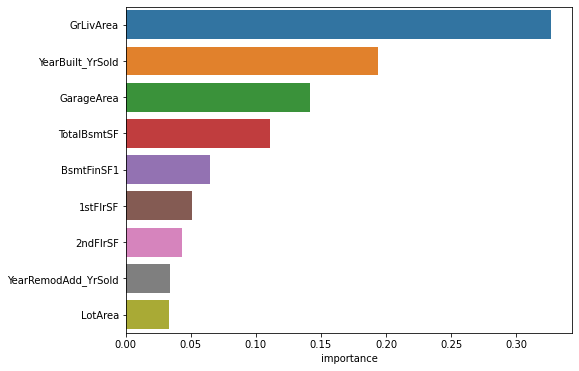

In [31]:
lst_columns = dct_performance[9]['features']

model = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
model.fit(X_train[lst_columns], y_train.values)

y_pred = model.predict(X_test[lst_columns])

print(f"RMSE: {mse(y_test, y_pred)**.5:.2f}")

df_importance = pd.DataFrame(
    model.feature_importances_, index=model.feature_names_in_, columns=['importance']
).sort_values(by='importance', ascending=False)


a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=df_importance, y=df_importance.index, x='importance', ax=ax);

In [32]:
x_test_kaggle_reduced = x_test_kaggle[lst_columns].copy()

y_pred_kaggle = model.predict(x_test_kaggle_reduced[lst_columns])
y_pred_kaggle = pd.DataFrame(y_pred_kaggle, index=x_test_kaggle_reduced.index, columns=['SalePrice']).reset_index()
y_pred_kaggle.rename(columns={'index':'Id'}, inplace=True)
y_pred_kaggle.sample(10, random_state=RANDOM_STATE)

,Id,SalePrice
1321,2782,101934.00
836,2297,316040.85
413,1874,142658.00
522,1983,201500.68
1035,2496,224459.80
614,2075,144243.00
218,1679,396445.75
1031,2492,189535.32
1289,2750,137106.25
886,2347,207228.44


In [33]:
y_pred_kaggle.to_csv(PROCESSED_FOLDER + 'y_pred_kaggle_2nd_dataset_rfr_feature_selection.csv', index=False)

# 6th experiment: 